### Embedding Performance
I will evaluate the quality of 9 embedding models (Word2Vec, GloVe, RoBERTa, Paraphrase-MPNET, HKU_INSTRUCTOR, MiniLMs, OpenAI, etc.) by measuring how well their vector spaces capture semantic structure in Yelp reviews

In [3]:
import numpy as np
from sklearn.preprocessing import normalize
import pandas as pd

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from umap import UMAP
from scipy.stats import spearmanr

from sklearn.feature_extraction.text import TfidfVectorizer
import scipy.stats as st

In [4]:
# Load .env
from dotenv import load_dotenv
load_dotenv()

True

In [5]:
from open_ai_review_embeddings import generate_theme_label

#### View embeddings dimensions for each model

In [6]:
# Define paths (adjust to your filenames)
model_paths = {
    "Glove300": "glove_300_embeddings.npy",
    "Word2Vec": "word_2_vec_embeddings.npy",
    "RoBERTa": "all_distill_roberta_v1_embeddings.npy",
    "HKU_INSTRUCTOR": "hku_nlp_instructor_embeddings.npy",
    "MiniLM-L6": "all_mini_LM_L6_v2_embeddings.npy",
    "MiniLM-L12": "all_mini_LM_L12_v2_embeddings.npy",
    "Paraphrase-MPNET": "paraphrase_mpnet_base_v2_embeddings.npy",
    "Paraphrase-MiniLM-L3": "paraphrase_mini_LM_L3_v2_embeddings.npy",
    "Open-AI-Text-Embedding": "open_ai_text_small_embeddings.npy"
}

# Load and normalize embeddings
models = {}
for name, path in model_paths.items():
    emb = np.load(f"embeddings/{path}")
    models[name] = normalize(emb)
    print(f"{name:25s} loaded: {emb.shape}")

Glove300                  loaded: (1000, 300)
Word2Vec                  loaded: (1000, 300)
RoBERTa                   loaded: (1000, 768)
HKU_INSTRUCTOR            loaded: (1000, 768)
MiniLM-L6                 loaded: (1000, 384)
MiniLM-L12                loaded: (1000, 384)
Paraphrase-MPNET          loaded: (1000, 768)
Paraphrase-MiniLM-L3      loaded: (1000, 384)
Open-AI-Text-Embedding    loaded: (1000, 1536)


#### Embeddings Performance
We want to evaluate how well each embedding space separates distinct clusters of reviews.

#### Quantitative
If embeddings capture meaningful themes or sentiment differences, KMeans should form tighter and more separated clusters, giving a higher silhouette score.

### Metric: Silhouette Score "Overall Clustering Quality"
Quantifies how well embeddings group semantically similar reviews. 
Silhouette score calculation is based on point-to-point distances
- Measures separation (between clusters) and cohesion (within clusters).
- Range: –1 → 1; higher = tighter, well-separated clusters.

| Range        | Meaning              | What’s happening                                                          |
| ------------ | -------------------- | ------------------------------------------------------------------------- |
| **+1.0**     | Perfectly clustered  | Point is much closer to its own cluster than to others (tight & distinct) |
| **0.0**      | Overlapping clusters | Point lies equally close to its own and a neighboring cluster             |
| **Negative** | Misclassified        | Point is closer to another cluster than to its own                        |


In [7]:
# Evaluate KMeans clustering on normalized embeddings
# Help of ChatGPT
k = 8  # number of clusters
silhouette_scores = {}
model_cluster_labels = {}

print("\n=== Normalized Embedding Clustering Comparison (KMeans k=8) ===")
for model_name, model_embeddings in models.items():

    # different embeddings dimensions 
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    review_labels = kmeans.fit_predict(model_embeddings)

    model_cluster_labels[model_name] = review_labels
    silhouette_scores[model_name] = silhouette_score(model_embeddings, review_labels)

# Sort silhouette score
sorted_silhouette_scores = dict(sorted(silhouette_scores.items(), key=lambda x: x[1], reverse=True))

print("\n=== Sorted Silhouette (Normalized) scores ===")
for model_name, model_silhouette_score in sorted_silhouette_scores.items():
    print(f"{model_name:25s} → {model_silhouette_score:.3f}")


=== Normalized Embedding Clustering Comparison (KMeans k=8) ===

=== Sorted Silhouette (Normalized) scores ===
Paraphrase-MPNET          → 0.033
Open-AI-Text-Embedding    → 0.027
HKU_INSTRUCTOR            → 0.023
Paraphrase-MiniLM-L3      → 0.021
Glove300                  → 0.021
RoBERTa                   → 0.020
MiniLM-L6                 → 0.017
MiniLM-L12                → 0.014
Word2Vec                  → 0.014


#### Qualitative
Visually show how clusters look in 2D space

/Users/safarifgisa/venvs/python3/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


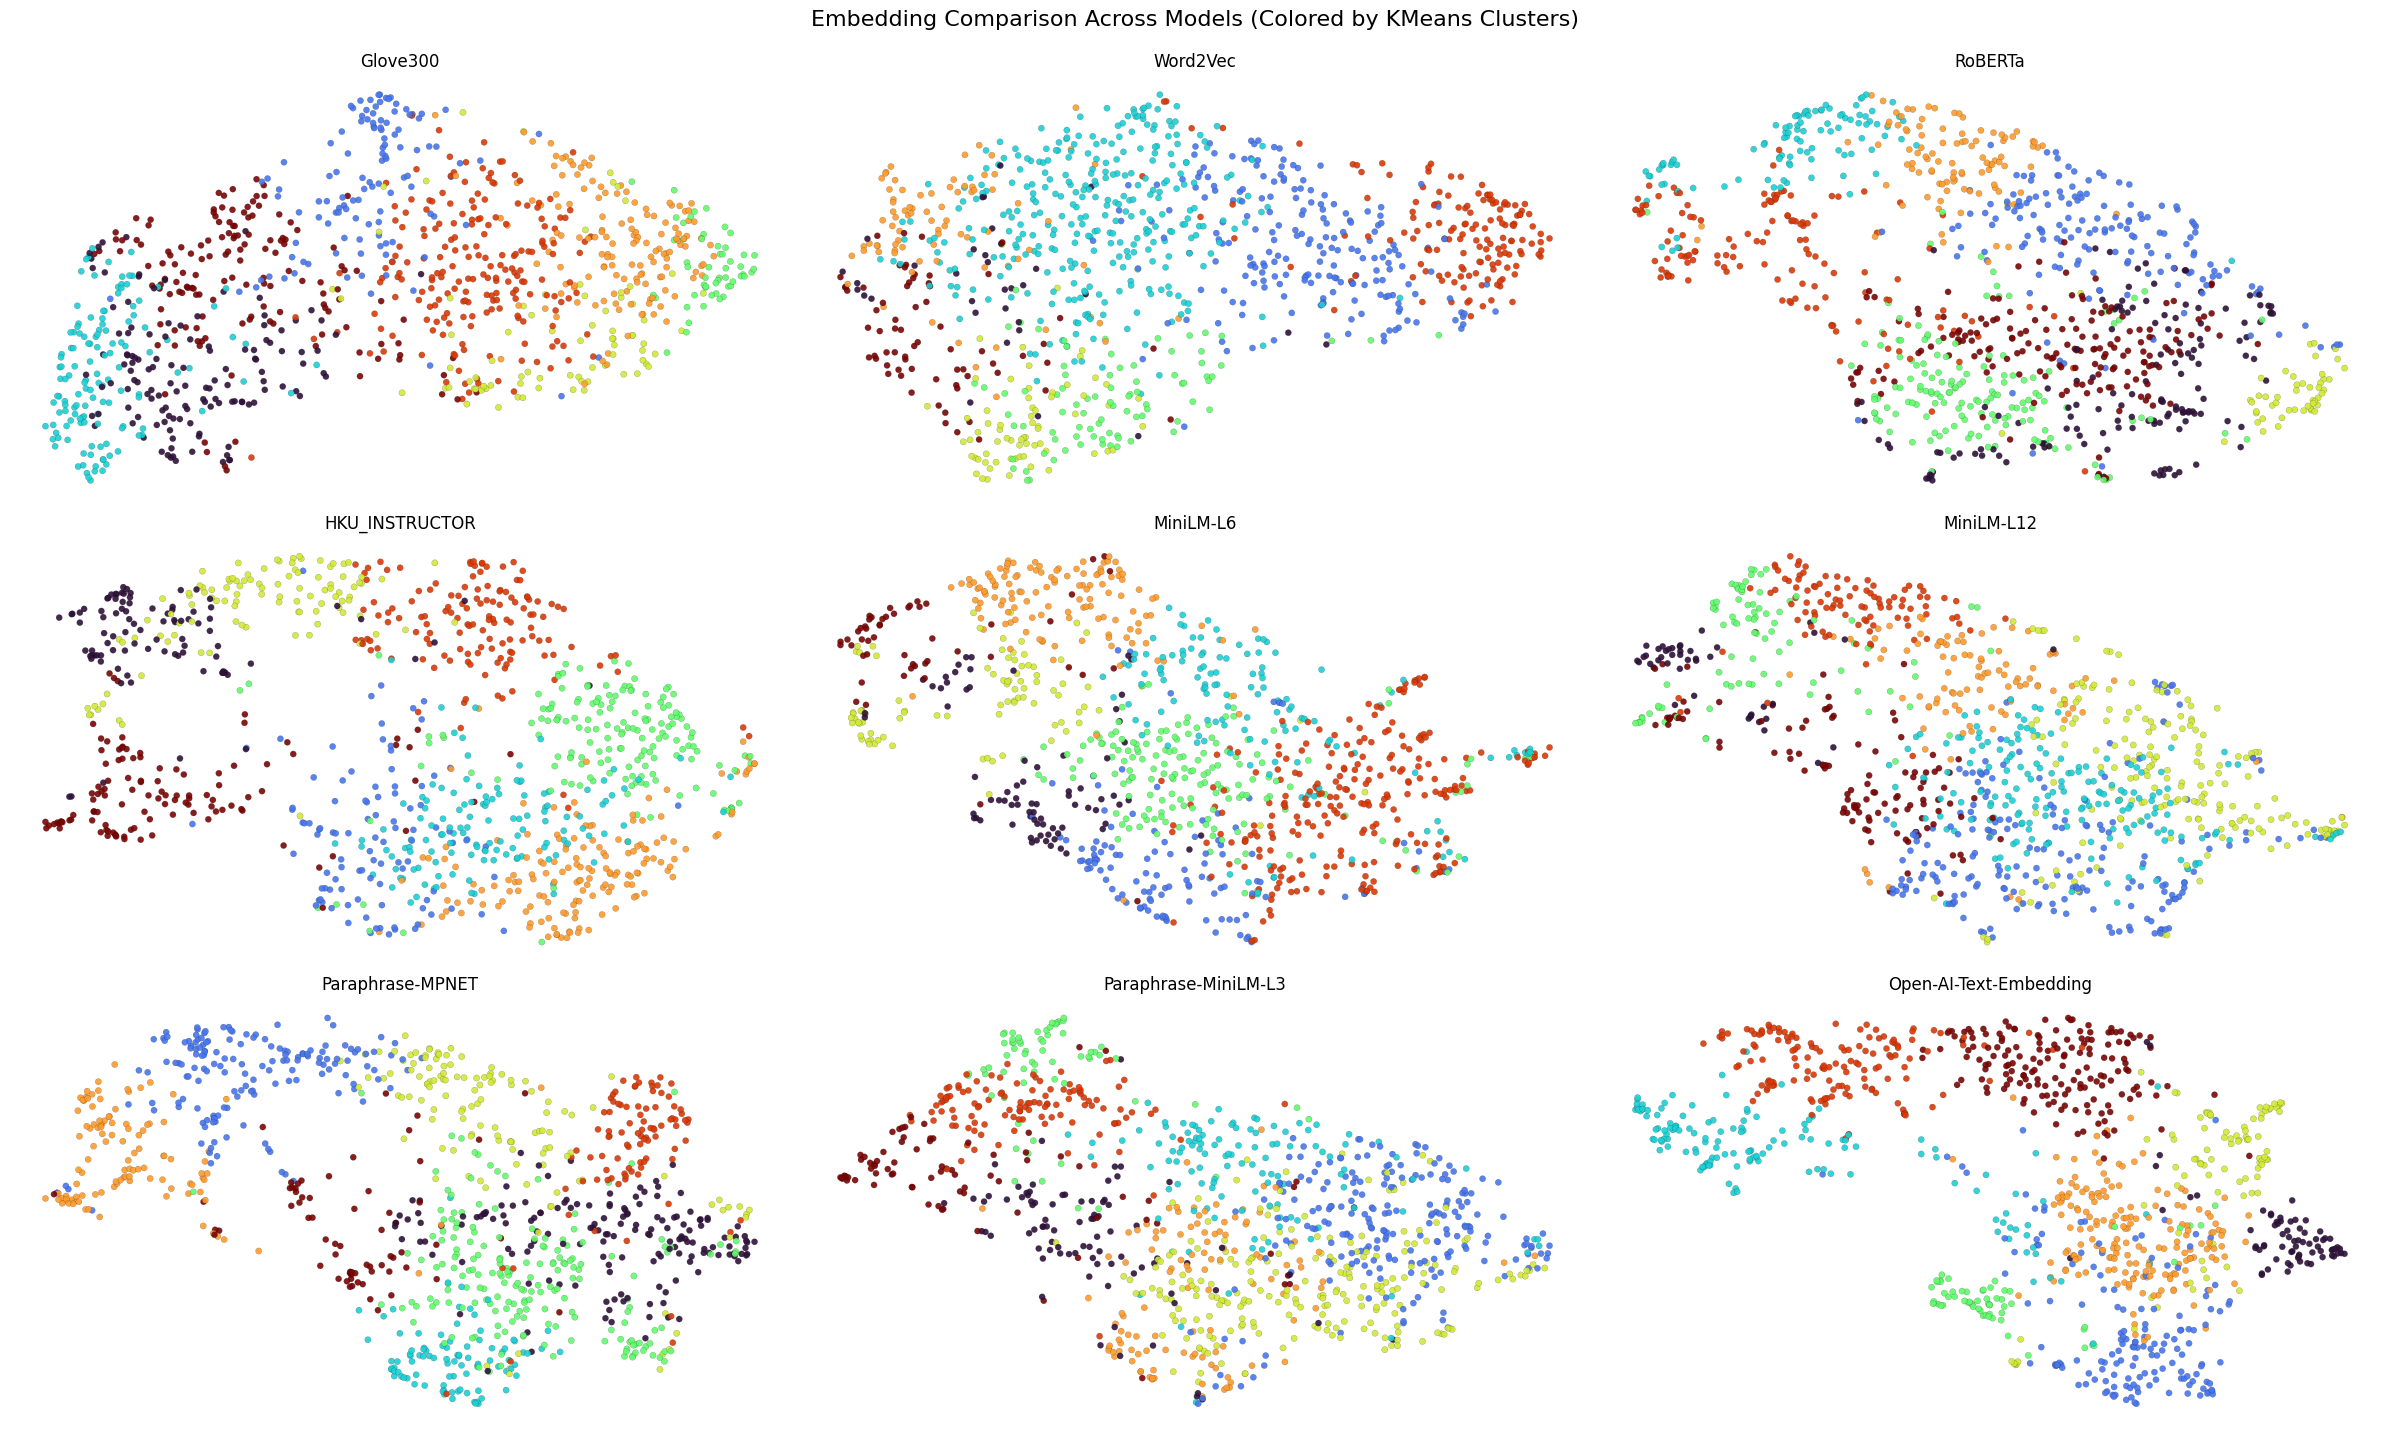

In [60]:
# UMAP visualization with cluster coloring
reducer = UMAP(n_components=2, random_state=42)
n_models = len(models)
n_cols = 3
n_rows = int(np.ceil(n_models / n_cols))

plt.figure(figsize=(24, 14))

for i, (model_name, model_embeddings) in enumerate(models.items()):
    
    labels = model_cluster_labels[model_name]
    
    # Reduce to 2D
    emb_2d = reducer.fit_transform(model_embeddings)
    
    # Plot clusters
    plt.subplot(n_rows, n_cols, i + 1)
    plt.scatter(
        emb_2d[:, 0],
        emb_2d[:, 1],
        c=labels,
        s=20,
        cmap='turbo',
        alpha=0.9,
        edgecolor='k',
        linewidth=0.1
    )
    plt.title(model_name)
    plt.axis("off")

plt.tight_layout()
plt.suptitle("Embedding Comparison Across Models (Colored by KMeans Clusters)", fontsize=16, y=1.02)
plt.show()


#### Cluster-level Silhouette scores for Embedding Models (per-point score)
Compute Mean Silhouette Scores for each cluster to identify strong/weak clusters for each embedding model. We calculate silhouette score for each point, then average those scores for points within same cluster.

From sklearn documentation:
"The Silhouette Coefficient is a measure of how well samples are clustered with samples that are similar to themselves. Clustering models with a high Silhouette Coefficient are said to be dense, where samples in the same cluster are similar to each other, and well separated, where samples in different clusters are not very similar to each other"

In [9]:
k = 8  # same as before

for model_name, model_embeddings in models.items():
    labels = model_cluster_labels[model_name]

    # Compute silhouette value for each sample; silhouette value for each individual sample
    sil_samples = silhouette_samples(model_embeddings, labels)

    # Compute average silhouette per cluster
    cluster_sil_means = []
    for cluster_id in range(k):
        cluster_sil_means.append(sil_samples[labels == cluster_id].mean())

    cluster_df = pd.DataFrame({
        "Cluster": range(k),
        "Silhouette": cluster_sil_means
    }).sort_values("Silhouette", ascending=False)

    print(f"\n=== {model_name} per-cluster Silhouette (K={k}) ===")
    print(cluster_df.to_string(index=False))



=== Glove300 per-cluster Silhouette (K=8) ===
 Cluster  Silhouette
       6    0.091571
       0    0.075806
       2    0.011912
       5    0.010535
       3    0.007820
       1   -0.002504
       7   -0.026510
       4   -0.079390

=== Word2Vec per-cluster Silhouette (K=8) ===
 Cluster  Silhouette
       2    0.077140
       6    0.026109
       4    0.006814
       5    0.002698
       3   -0.021065
       1   -0.034086
       7   -0.054586
       0   -0.080338

=== RoBERTa per-cluster Silhouette (K=8) ===
 Cluster  Silhouette
       4    0.073459
       7    0.047775
       5    0.038715
       3    0.036164
       1    0.017492
       2    0.016001
       6   -0.014360
       0   -0.023886

=== HKU_INSTRUCTOR per-cluster Silhouette (K=8) ===
 Cluster  Silhouette
       2    0.081521
       6    0.047140
       0    0.028870
       4    0.025873
       3    0.016208
       7    0.013634
       5   -0.008659
       1   -0.026346

=== MiniLM-L6 per-cluster Silhouette (K=8) ===
 Cl

#### Measuring cluster sizes and balance
Are cluster sizes balanced, or did one model collapse all reviews into one blob?
- Entropy : measure of the amount of uncertainty or randomness in a probability distribution

- Lower cluster entropy -> clusters are more coherent, meaning reviews within a cluster tend to share more similar themes or topics (less internal confusion)

- Higher cluster entropy -> clusters contain a more mixed set of themes or semantics — i.e., less separation between underlying topics

- Moderate range is desirable -> signals cluster size balance

In [10]:
for name, labels in model_cluster_labels.items():
    counts = np.bincount(labels)
    entropy = st.entropy(counts)
    print(f"{name:25s} → Cluster entropy: {entropy:.3f}, range: {counts.min()}–{counts.max()}")

Glove300                  → Cluster entropy: 2.020, range: 53–199
Word2Vec                  → Cluster entropy: 1.862, range: 33–314
RoBERTa                   → Cluster entropy: 2.032, range: 50–166
HKU_INSTRUCTOR            → Cluster entropy: 2.060, range: 93–164
MiniLM-L6                 → Cluster entropy: 1.986, range: 52–244
MiniLM-L12                → Cluster entropy: 1.993, range: 45–196
Paraphrase-MPNET          → Cluster entropy: 2.030, range: 66–189
Paraphrase-MiniLM-L3      → Cluster entropy: 1.994, range: 68–214
Open-AI-Text-Embedding    → Cluster entropy: 2.019, range: 62–181


#### Cluster consistency - Average internal similarity of all clusters
Do the reviews grouped together actually “talk about the same thing”?
It quantifies the average similarity between embeddings of reviews within the same cluster.

In [11]:
def cluster_consistency(embeddings, labels):
    sims = []
    for cluster in np.unique(labels):
        cluster_emb = embeddings[labels == cluster]
        if len(cluster_emb) > 5:
            sim = cosine_similarity(cluster_emb).mean()
            sims.append(sim)
    return np.mean(sims)

In [12]:
for model_name, model_embeddings in models.items():
    labels = model_cluster_labels[model_name]
    consistency = cluster_consistency(model_embeddings, labels)
    print(f"{model_name:25s} → Cluster Consistency: {consistency:.3f}")

Glove300                  → Cluster Consistency: 0.785
Word2Vec                  → Cluster Consistency: 1.000
RoBERTa                   → Cluster Consistency: 0.406
HKU_INSTRUCTOR            → Cluster Consistency: 0.608
MiniLM-L6                 → Cluster Consistency: 0.351
MiniLM-L12                → Cluster Consistency: 0.369
Paraphrase-MPNET          → Cluster Consistency: 0.461
Paraphrase-MiniLM-L3      → Cluster Consistency: 0.288
Open-AI-Text-Embedding    → Cluster Consistency: 0.394


#### Finding semantically close reviews

In [27]:
# Load samples
samples_df = pd.read_parquet("data/sample_reviews.parquet")

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [59]:
pd.set_option('display.max_colwidth', None)  # show full text (no truncation)
samples_df[samples_df.text.str.contains('love')]['text'].head(50)
#12 amazing food, amazing service, food recommendations
#13 bad service, bad food

#337 recommendation; check this place out
#492 check engine light

#32 great food; great burger
#887 not good; terrible meat, rice, beans, slow service, not friendly

#172
#44

11                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

In [32]:
samples_df[samples_df.business_id == '3zK9LTY3TgH7nU18'].head()

,review_id,business_id,stars,categories,date,text,lemmas,num_lemmas,month,review_length,avg_word_length


In [14]:
# Assign cluster ids from each model to each review
for name, labels in model_cluster_labels.items():
    samples_df[f"{name}_cluster"] = labels

In [15]:
samples_df.head(3)

,review_id,business_id,stars,categories,date,text,lemmas,num_lemmas,month,review_length,avg_word_length,Glove300_cluster,Word2Vec_cluster,RoBERTa_cluster,HKU_INSTRUCTOR_cluster,MiniLM-L6_cluster,MiniLM-L12_cluster,Paraphrase-MPNET_cluster,Paraphrase-MiniLM-L3_cluster,Open-AI-Text-Embedding_cluster
0,G4M9NZ7Xvr4CKY_NPeD8LQ,5DwRX43KmGroXBlltpCGqA,1.0,"Irish, Restaurants",2022-01-03 18:19:40,Have never been there and have lived here for ...,live long time go friend time new year eve cho...,33,1,457,4.0,0,2,1,6,3,2,4,2,7
1,IbSwiO2OkX6DrBZIQ8ofQg,gyY3NIjsfGF5SUbr5PdmHA,5.0,"Pizza, Bars, Lounges, Restaurants, Nightlife, ...",2022-01-14 15:31:32,This was our first try of Georgio's and we'll ...,try georgio definitely pick order look mediter...,26,1,339,5.0,5,4,7,5,6,4,0,1,0
2,eAVYs7Lo90AQ-GzbcrsseQ,cx2fwY66_xTNFo0p2EEC4g,5.0,"American (New), Indian, Event Planning & Servi...",2022-01-18 19:43:36,Great Indian food in Media Borough. Right on s...,great indian food media borough right state st...,18,1,164,5.0,1,4,3,5,6,1,3,4,4


In [16]:
print(samples_df.iloc[500]['text'])

samples_df.iloc[500]
# meh service, food is okay...very neutral
# poor drink quality, poor service/attitude, harsh service, customer service etiquette is poor

Drinks aren't good, but most importantly the staff is awful. They are abrasive. After looking at the other reviews, I would not be surprised if the allegations here were true. Seems like they need some better training here on how to talk to people.


review_id                                                    8ArQo7BwFcoxOrLOKsHwwA
business_id                                                  LG9WtCRXx_PAr0y4nO0qjg
stars                                                                           1.0
categories                        Bakeries, Bagels, Coffee & Tea, Food, Restaura...
date                                                            2022-01-06 19:55:48
text                              Drinks aren't good, but most importantly the s...
lemmas                            drink good importantly staff awful abrasive lo...
num_lemmas                                                                       17
month                                                                             1
review_length                                                                   248
avg_word_length                                                                 5.0
Glove300_cluster                                                            

In [17]:
# Pick an index for the reference review
idx = 500

# For each model, find top-2 most similar reviews
for name, emb in models.items():
    sim_matrix = cosine_similarity([emb[idx]], emb)[0]
    
    # Get top-2 similar indices (excluding itself)
    top2_idx = np.argsort(sim_matrix)[-3:-1][::-1]
    
    print(f"\n=== {name} ===")
    print(f"Base review (idx={idx}):")
    print(samples_df.iloc[idx]['text'])
    
    for i, j in enumerate(top2_idx):
        print(f"\nSimilar {i+1} (idx={j}) | Cosine: {sim_matrix[j]:.3f}")
        print(samples_df.iloc[j]['text'])



=== Glove300 ===
Base review (idx=500):
Drinks aren't good, but most importantly the staff is awful. They are abrasive. After looking at the other reviews, I would not be surprised if the allegations here were true. Seems like they need some better training here on how to talk to people.

Similar 1 (idx=681) | Cosine: 0.912
My husband and I been coming here for about 4 years and the menu is amazing but the people that you guys hire they need some serious training. My server was very skidish and seemed she was crying I believe her name was Sam but please put more professional looking people at this establishment not a good look for a hotel like this.

Similar 2 (idx=31) | Cosine: 0.912
The entire staff was amazing, thorough, quick and friendly. It
goes along way having people actually love what they do! They have made the fear of going into places like this enjoyable for me! Hats off to you and the owners. Clearly they value their employees and it shows. Thanks for the battery change a

#### Cluster Interpretability
Turn cluster IDs into themes

In [18]:
def extract_top_terms(texts, n_top=10):
    vectorizer = TfidfVectorizer(
        stop_words='english',
        max_df=0.9,
        min_df=5,
        max_features=100
    )
    tfidf = vectorizer.fit_transform(texts)
    terms = np.array(vectorizer.get_feature_names_out())
    top_idx = np.argsort(tfidf.toarray().sum(axis=0))[-n_top:][::-1]
    return terms[top_idx].tolist()

In [19]:
# Run for each embedding model & cluster
records = []
for model_name, labels in model_cluster_labels.items():
    for cluster_id in sorted(np.unique(labels)):
        cluster_texts = samples_df.loc[labels == cluster_id, 'lemmas']
        if len(cluster_texts) < 10:
            continue
        top_terms = extract_top_terms(cluster_texts)
        theme_name = generate_theme_label(top_terms)
        records.append({
            "Model": model_name,
            "Cluster": cluster_id,
            "Top Terms": ", ".join(top_terms),
            "Suggested Theme": theme_name
        })

In [26]:
themes_df = pd.DataFrame(records)
themes_df[themes_df['Model'] == 'Paraphrase-MiniLM-L3']["Top Terms"].head(20) #HKU_INSTRUCTOR

56    good, great, place, staff, like, friendly, roo...
57    order, good, food, chicken, like, come, great,...
58    food, order, place, time, good, wait, restaura...
59    car, time, service, work, come, day, need, goo...
60    food, great, good, service, place, delicious, ...
61    good, place, great, coffee, love, come, drink,...
62    service, time, order, minute, place, customer,...
63    time, good, dr, love, great, place, look, nail...
Name: Top Terms, dtype: object

In [23]:
from keybert import KeyBERT
kw_model = KeyBERT(model='paraphrase-MiniLM-L6-v2')

for cluster_id in np.unique(labels):
    docs = samples_df.loc[labels == cluster_id, 'text']
    keywords = kw_model.extract_keywords(
        " ".join(docs),
        keyphrase_ngram_range=(1, 2),
        stop_words='english',
        use_maxsum=True,
        top_n=10
    )
    print(cluster_id, [kw for kw, _ in keywords])

0 ['dishes excellent', 'food good', 'delicious best', 'food pretty', 'recommend food', 'ordered food', 'greek food', 'delicious ordered', 'italian food', 'delicious spanicopia']
1 ['new brunch', 'food brunch', 'flavors brunch', 'brunch menu', 'brunch todays', 'weekend brunch', 'spot brunch', 'enjoyed cappuccino', 'brunch restaurants', 'brunch venue']
2 ['trailer dealership', 'cab cart', 'did van', 'exceptional customer', 've queens', 'team worked', 'appreciate company', 'membership busch', 'staff amazing', 'queens']
3 ['charro cafe', 'mexican tacos', 'house tacos', 'restaurants fiesta', 'vieja delicious', 'inside restaurant', 'restaurant heh', 'clean restaurant', 'restaurant serving', 'delicious mexican']
4 ['nice meal', 'food south', 'friendly food', 'food east', 'amazing food', 'food superb', 'meals perfect', 'got meals', 'meal try', 'indian food']
5 ['hospitality', 'restaurant cute', 'hospitality felt', 'restaurant came', 'excellent restaurant', 'helped restaurant', 'stuck hostesses